In [1]:
!pip install janome pandas scikit-learn seaborn --quiet > /dev/null 2>&1
!apt-get -y install fonts-ipafont-gothic > /dev/null 2>&1
!wget -O ldcc-20140209.tar.gz https://www.rondhuit.com/download/ldcc-20140209.tar.gz --quiet > /dev/null 2>&1
!tar -zxvf ldcc-20140209.tar.gz > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.font_manager as fm
ipa_font_path = "/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf"
ipa_font = fm.FontProperties(fname=ipa_font_path)

In [4]:
import os
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from janome.tokenizer import Tokenizer

In [5]:
# カテゴリ対応
category_map = {
    'dokujo-tsushin': '独女通信',
    'it-life-hack': 'ITライフハック',
    'kaden-channel': '家電チャンネル',
    'livedoor-homme': 'livedoor HOMME',
    'movie-enter': '映画',
    'peachy': 'Peachy',
    'smax': 'S-max',
    'sports-watch': 'スポーツ',
    'topic-news': 'トピック'
}
label_to_id = {v: i+1 for i, v in enumerate(category_map.values())}
id_to_label = {v: k for k, v in label_to_id.items()}

In [6]:
# データ読み込み
def load_livedoor_news_corpus():
    docs, labels = [], []
    for dir_name, label_name in category_map.items():
        files = glob.glob(f"./text/{dir_name}/{dir_name}*.txt")
        for file in files[:30]:
            with open(file, 'r', encoding='utf-8', errors='ignore') as f:
                lines = f.read().splitlines()
                if len(lines) < 4:
                    continue
                subject = lines[2]
                body = "".join(lines[3:])
                text = subject + body
                docs.append(text)
                labels.append(label_to_id[label_name])
    return docs, labels

print("データ読み込み中...")
docs, labels = load_livedoor_news_corpus()

データ読み込み中...


In [7]:
# データ分割
random.seed(42)
indices = list(range(len(docs)))
random.shuffle(indices)
split = int(len(docs) * 0.9)
train_data = [docs[i] for i in indices[:split]]
train_labels = [labels[i] for i in indices[:split]]
test_data = [docs[i] for i in indices[split:]]
test_labels = [labels[i] for i in indices[split:]]

In [8]:
# トークナイザー
t = Tokenizer()

def tokenize_selected_safe(text):
    tokens = [
        token.surface for token in t.tokenize(text)
        if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞', '形容動詞']
    ]
    return tokens if tokens else [token.surface for token in t.tokenize(text)]

In [9]:
# 特徴抽出
print("特徴量をTF-IDFに変換中...")
vectorizer = TfidfVectorizer(tokenizer=tokenize_selected_safe, min_df=1)
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

特徴量をTF-IDFに変換中...


In [10]:
# ランダムフォレスト
print("ランダムフォレスト分類中...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, train_labels)
rf_preds = rf_clf.predict(X_test)

print("\nRandomForest 精度レポート:")
target_names = [id_to_label[i] for i in sorted(set(labels))]
print(classification_report(test_labels, rf_preds, target_names=target_names))

ランダムフォレスト分類中...

RandomForest 精度レポート:
                precision    recall  f1-score   support

          独女通信       0.50      1.00      0.67         4
      ITライフハック       1.00      0.67      0.80         6
       家電チャンネル       0.50      1.00      0.67         1
livedoor HOMME       1.00      0.50      0.67         4
            映画       1.00      0.75      0.86         4
        Peachy       0.50      0.33      0.40         3
         S-max       1.00      1.00      1.00         2
          スポーツ       1.00      1.00      1.00         1
          トピック       0.67      1.00      0.80         2

      accuracy                           0.74        27
     macro avg       0.80      0.81      0.76        27
  weighted avg       0.83      0.74      0.74        27



In [11]:
# ナイーブベイズ
print("ナイーブベイズ分類中...")
nb_clf = MultinomialNB()
nb_clf.fit(X_train, train_labels)
nb_preds = nb_clf.predict(X_test)

print("\nNaiveBayes 精度レポート:")
print(classification_report(test_labels, nb_preds, target_names=target_names))

ナイーブベイズ分類中...

NaiveBayes 精度レポート:
                precision    recall  f1-score   support

          独女通信       0.36      1.00      0.53         4
      ITライフハック       1.00      0.33      0.50         6
       家電チャンネル       0.33      1.00      0.50         1
livedoor HOMME       1.00      0.50      0.67         4
            映画       1.00      0.50      0.67         4
        Peachy       0.00      0.00      0.00         3
         S-max       0.40      1.00      0.57         2
          スポーツ       1.00      1.00      1.00         1
          トピック       1.00      0.50      0.67         2

      accuracy                           0.56        27
     macro avg       0.68      0.65      0.57        27
  weighted avg       0.73      0.56      0.53        27



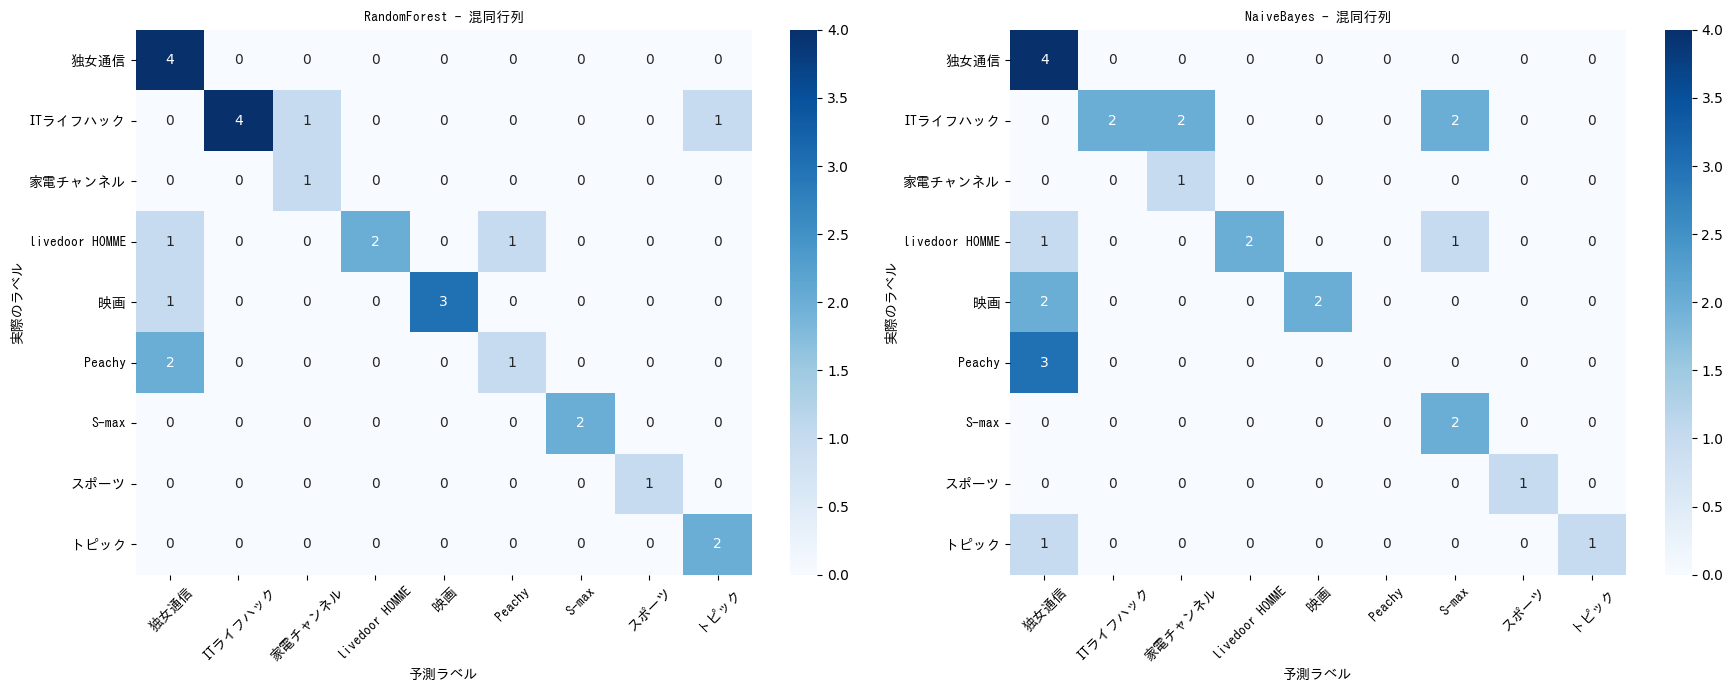

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 混同行列を横並びで表示
cm_rf = confusion_matrix(test_labels, rf_preds, labels=sorted(set(labels)))
cm_nb = confusion_matrix(test_labels, nb_preds, labels=sorted(set(labels)))
ticklabels = [id_to_label[i] for i in sorted(set(labels))]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 左：RandomForest
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=ticklabels, yticklabels=ticklabels,
            ax=axes[0])
axes[0].set_title("RandomForest - 混同行列", fontproperties=ipa_font)
axes[0].set_xlabel("予測ラベル", fontproperties=ipa_font)
axes[0].set_ylabel("実際のラベル", fontproperties=ipa_font)
axes[0].set_xticklabels(ticklabels, fontproperties=ipa_font, rotation=45)
axes[0].set_yticklabels(ticklabels, fontproperties=ipa_font, rotation=0)

# 右：NaiveBayes
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues",
            xticklabels=ticklabels, yticklabels=ticklabels,
            ax=axes[1])
axes[1].set_title("NaiveBayes - 混同行列", fontproperties=ipa_font)
axes[1].set_xlabel("予測ラベル", fontproperties=ipa_font)
axes[1].set_ylabel("実際のラベル", fontproperties=ipa_font)
axes[1].set_xticklabels(ticklabels, fontproperties=ipa_font, rotation=45)
axes[1].set_yticklabels(ticklabels, fontproperties=ipa_font, rotation=0)

plt.tight_layout()
plt.show()